# Lagrangian Jacobian optimization

## Import statements

In [2]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
np.set_printoptions(linewidth=1000)
from scipy.sparse.linalg import lgmres
import sympy as sp


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

## Set up A $\phi$ = B case
Set up an example A*$\phi$ = B problem where there are negative Jacobian determinant values

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (25, 25), A.todense(): (25, 25), A0: (25, 25), A_expanded: (50, 50)
A shape: (25, 25)
[[ 2. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_52258/461045267.py:42: DeprecationWarning: 'scipy.sparse.linalg.lgmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]
/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_52258/461045267.py:42: DeprecationWarning: 'scipy.sparse.linalg.lgmres' called without specifying `atol`. This behavior is deprecated and will result in an error in SciPy v1.14.0. To preserve current behaviour, set `atol=rtol`, or, to adopt the future default, set `atol=0.0`.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


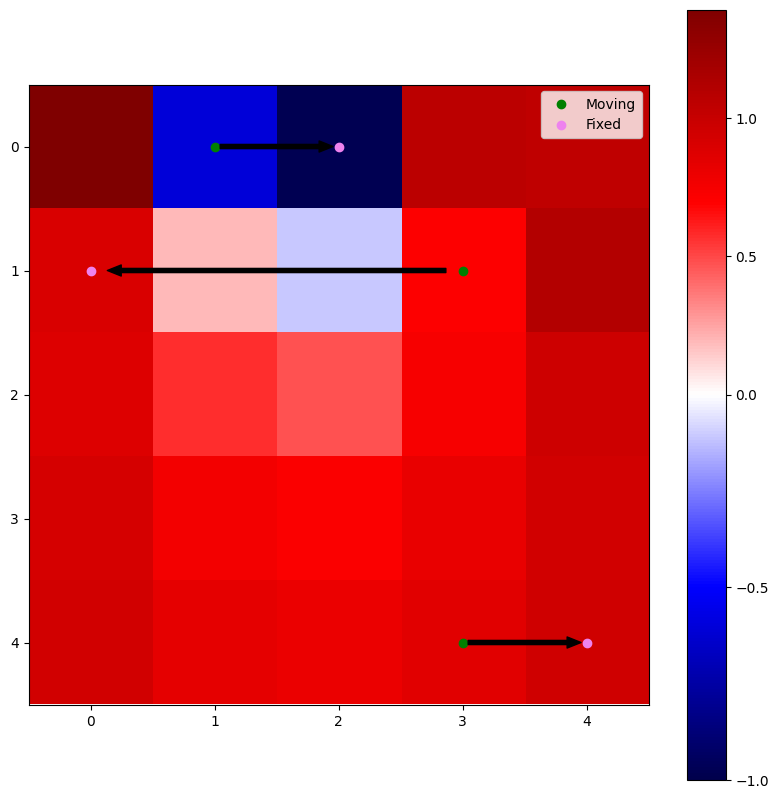

In [ ]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 1, 3],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 1, 0],  # Middle
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
A0 = np.zeros((A.shape[0], A.shape[1]))

# Creating the big combined Laplacian matrix
A_expanded = np.block([
    [A.todense(), A0],
    [A0, A.todense()]
])
XYd = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]
print(f'A shape: {A.shape}, A.todense(): {A.todense().shape}, A0: {A0.shape}, A_expanded: {A_expanded.shape}')

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

In [4]:
print(deformation[2, 0, :, :])

[[ 2.21731268  2.9997301  -0.99991003 -0.95725005 -0.87627159]
 [ 1.43327002  1.21656845 -0.19010971 -0.99991003 -0.7967012 ]
 [ 0.87714422  0.6274356   0.02073177 -0.42202005 -0.50670507]
 [ 0.56616476  0.39373907  0.07601421 -0.19027739 -0.30068362]
 [ 0.43551737  0.30725252  0.09106877 -0.10077189 -0.19919557]]


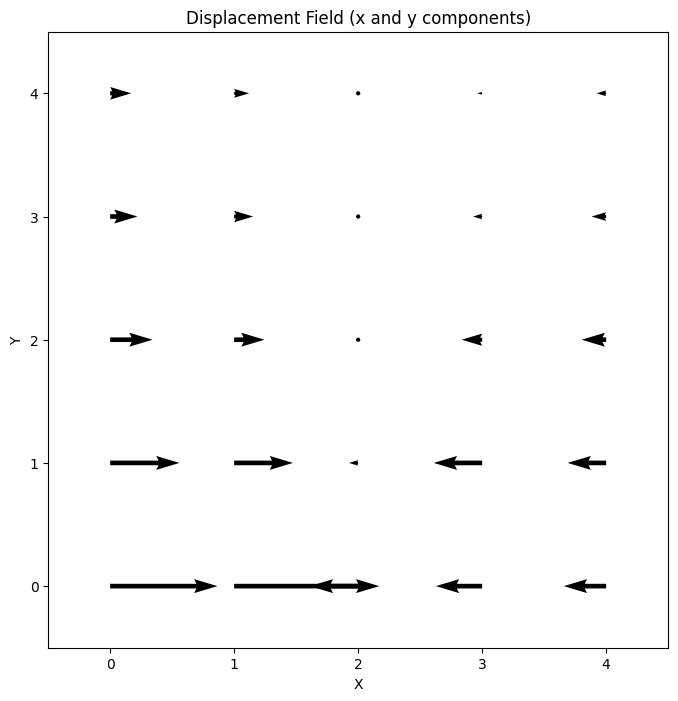

[[ 2.21731268  2.9997301  -0.99991003 -0.95725005 -0.87627159]
 [ 1.43327002  1.21656845 -0.19010971 -0.99991003 -0.7967012 ]
 [ 0.87714422  0.6274356   0.02073177 -0.42202005 -0.50670507]
 [ 0.56616476  0.39373907  0.07601421 -0.19027739 -0.30068362]
 [ 0.43551737  0.30725252  0.09106877 -0.10077189 -0.19919557]]


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Example displacement field (3x1x5x5)
displacement_field = np.random.rand(3, 1, 5, 5)  # Replace with your actual displacement field
displacement_field = deformation


# Create a grid of points
x, y = np.meshgrid(np.arange(displacement_field.shape[3]), np.arange(displacement_field.shape[2]))

# Extract the x and y displacement components
u = displacement_field[2, 0, :, :]  # Displacement in x-direction
v = displacement_field[1, 0, :, :]  # Displacement in y-direction

# Plot the displacement vectors using a quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.title('Displacement Field (x and y components)')
plt.xlim(-0.5, displacement_field.shape[3] - 0.5)
plt.ylim(-0.5, displacement_field.shape[2] - 0.5)
#plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X')
plt.ylabel('Y')
#plt.grid()
plt.show()

print(u)

In [6]:
l_idx = laplacian.get_laplacian_index(0, 1, 1, fixed_sample.shape)
print(l_idx)

6


## Set up Scipy optimizer

In [7]:
def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

Scipy minimizer

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustconstr.html

In [8]:
laplacian.get_laplacian_index(0, 0, 1, fixed_sample.shape)

1

In [9]:
import numpy as np
from scipy.optimize import minimize

# Define the matrix A and vector B

# A_ is [[L,0], [0,L]]
# b_ is [[x],[y]]
A_ = A_expanded
b_ = XYd

# Define the objective function
def objective(phi):
    return np.linalg.norm(A_ @ phi - b_)**2

y_offset = len(b_) // 2
idx_adj = idx_adjacency(fixed_sample.shape)

# Define the constraints
def jdet_constraint(phi, idx, epsilon=1e-6):
    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

# Create the constraints
constraints = []
for i in range(len(b_) // 2):
    constraints += [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i)}]

# Initial guess
phi0 = phi_xy

# Solve the optimization problem
result = minimize(objective, phi0, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method='SLSQP')

# Display the solutions
if result.success:
    print("phi0 error:", objective(phi0))
    print("result error:", result.fun)
    print("Solutions:")
    for i in range(len(result.x)):
        print(f"phi{i + 1} = {result.x[i]}")
else:
    print("Optimization failed:", result.message)
x_field = result.x[:len(result.x) // 2].reshape(fixed_sample.shape)
y_field = result.x[len(result.x) // 2:].reshape(fixed_sample.shape)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.0380178052106426
            Iterations: 55
            Function evaluations: 2863
            Gradient evaluations: 55
phi0 error: 0.0009896260006198759
result error: 2.0380178052106426
Solutions:
phi1 = 1.452957774517563
phi2 = 1.9670502796038112
phi3 = -0.560768929302339
phi4 = -0.19307116681969452
phi5 = -0.0023830602455413175
phi6 = 1.0606397929911322
phi7 = 0.9556887318143439
phi8 = 0.10018847428258038
phi9 = -0.4063233378905097
phi10 = -0.05792801332849256
phi11 = 0.8116937249346071
phi12 = 0.6842801623702254
phi13 = 0.34430533760578313
phi14 = 0.10643348156942772
phi15 = 0.132710850675598
phi16 = 0.6942234005572594
phi17 = 0.6096961249207938
phi18 = 0.44946061715033125
phi19 = 0.3216719097023375
phi20 = 0.28920679026104285
phi21 = 0.6507657548057956
phi22 = 0.5912597956940804
phi23 = 0.49174075523604205
phi24 = 0.4054008214195754
phi25 = 0.36754136054270564
phi26 = 0.0018868032124808474


SITK deformation shape: (1, 5, 5, 3)
Minimum Jacobian determinant: -0.9784900784492825
Maximum Jacobian determinant: 1.3912087107222522
Number of negative Jacobian determinants: 3
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 22
Jacobian det at 0, 1, 1: 0.18831013517261885
Jacobian det at 0, 0, 1: -0.6086113572776348


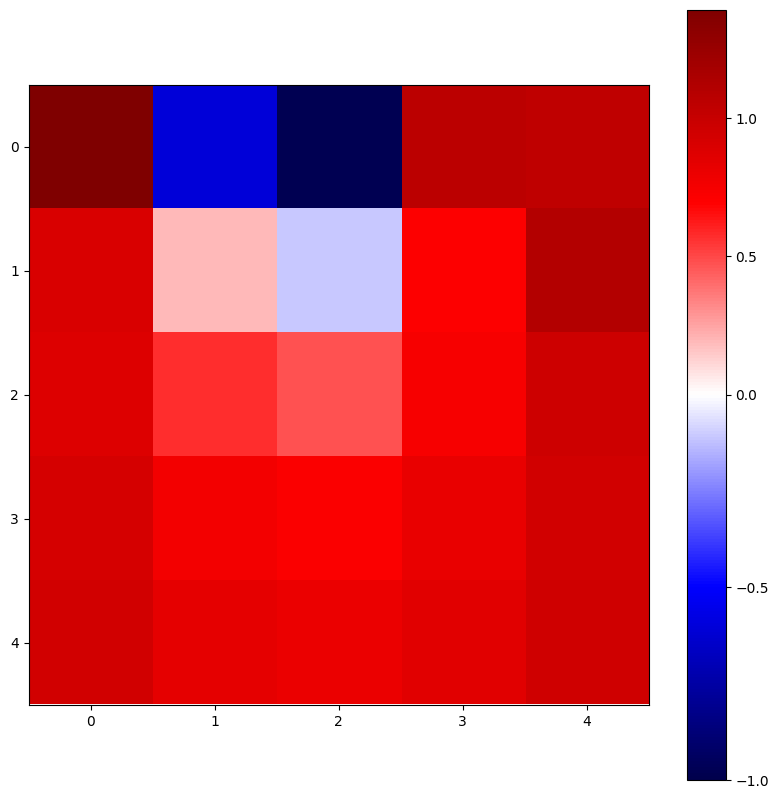

In [10]:
# Set deformation field from result
z_field = np.zeros(fixed_sample.shape)
def_field = deformation
#print(def_field.shape)

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(def_field)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

print("Jacobian det at 0, 1, 1:", jacobian_det[0, 1, 1])
print("Jacobian det at 0, 0, 1:", jacobian_det[0, 0, 1])

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()


(3, 1, 5, 5)
SITK deformation shape: (1, 5, 5, 3)
Minimum Jacobian determinant: 9.791062446327936e-07
Maximum Jacobian determinant: 1.250074368314757
Number of negative Jacobian determinants: 0
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 25
Jacobian det at 0, 1, 1: 0.39340884685935174
Jacobian det at 0, 0, 1: 9.791062446327936e-07


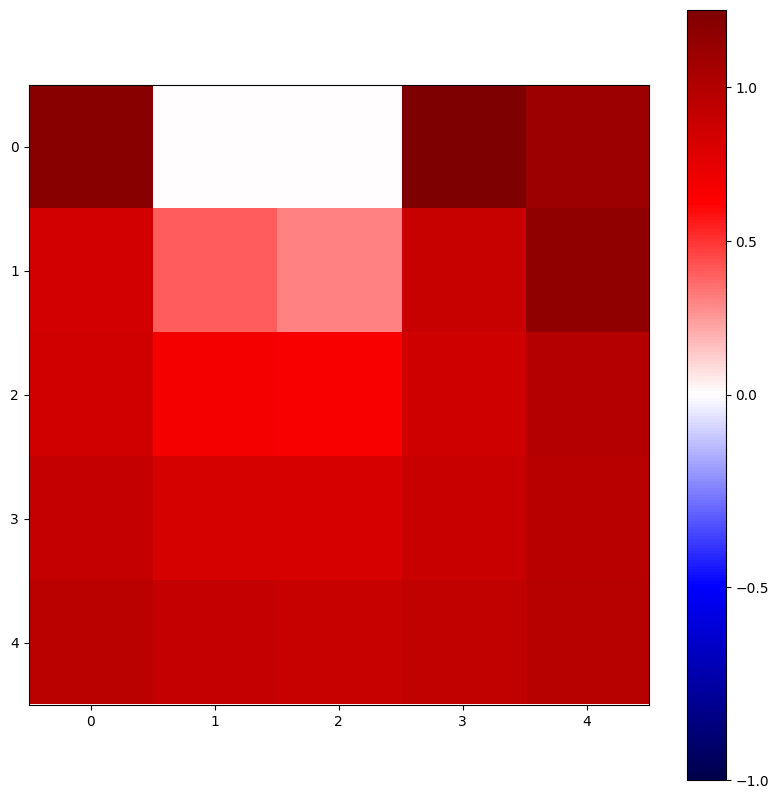

In [11]:
# Set deformation field from result
z_field = np.zeros(fixed_sample.shape)
def_field = np.stack([z_field, y_field, x_field], axis=0)
print(def_field.shape)

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(def_field)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

print("Jacobian det at 0, 1, 1:", jacobian_det[0, 1, 1])
print("Jacobian det at 0, 0, 1:", jacobian_det[0, 0, 1])

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()


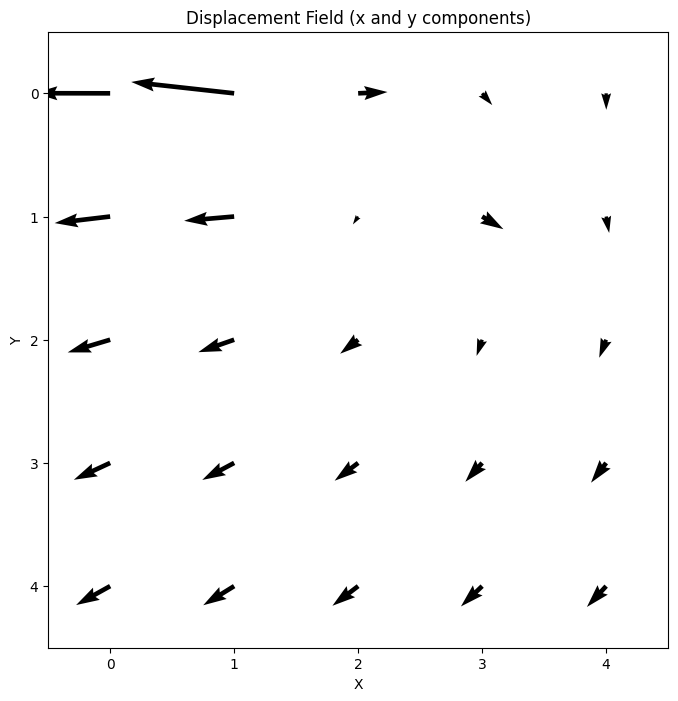

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Example displacement field (3x1x5x5)
displacement_field = np.random.rand(3, 1, 5, 5)  # Replace with your actual displacement field
displacement_field = def_field


# Create a grid of points
x, y = np.meshgrid(np.arange(displacement_field.shape[3]), np.arange(displacement_field.shape[2]))

# Extract the x and y displacement components
u = -displacement_field[2, 0, :, :]  # Displacement in x-direction
v = displacement_field[1, 0, :, :]  # Displacement in y-direction

# Plot the displacement vectors using a quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.title('Displacement Field (x and y components)')
plt.xlim(-0.5, displacement_field.shape[3] - 0.5)
plt.ylim(-0.5, displacement_field.shape[2] - 0.5)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X')
plt.ylabel('Y')
#plt.grid()
plt.show()

Do this just for a good case

Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[ 0.  0. -1.  0.  0.  0.  0. -2.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.        ]
   [ 0.          0.  

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_52258/3773044062.py:42: DeprecationWarning: 'scipy.sparse.linalg.lgmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]
/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_52258/3773044062.py:42: DeprecationWarning: 'scipy.sparse.linalg.lgmres' called without specifying `atol`. This behavior is deprecated and will result in an error in SciPy v1.14.0. To preserve current behaviour, set `atol=rtol`, or, to adopt the future default, set `atol=0.0`.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


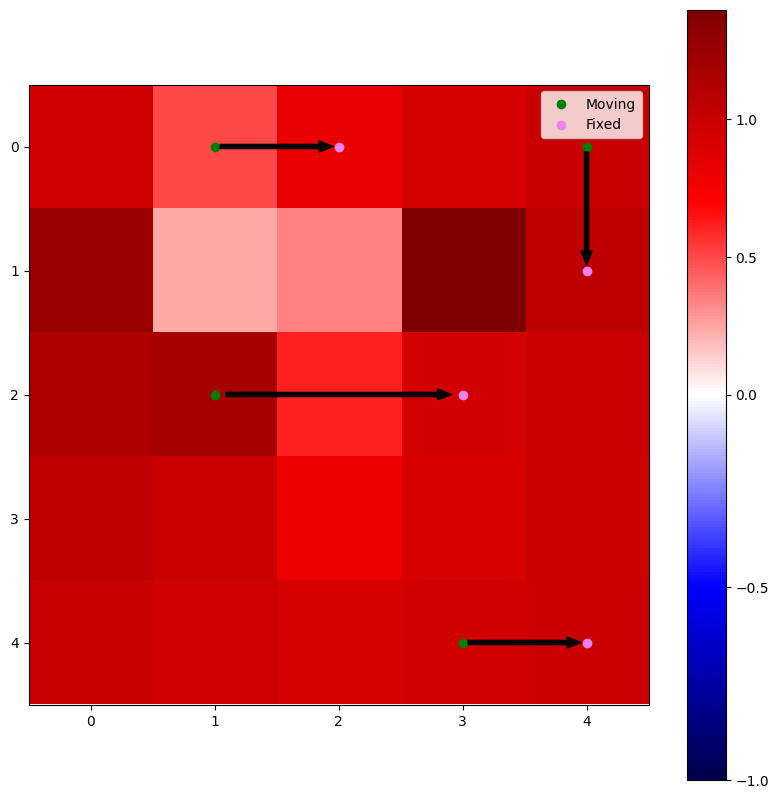

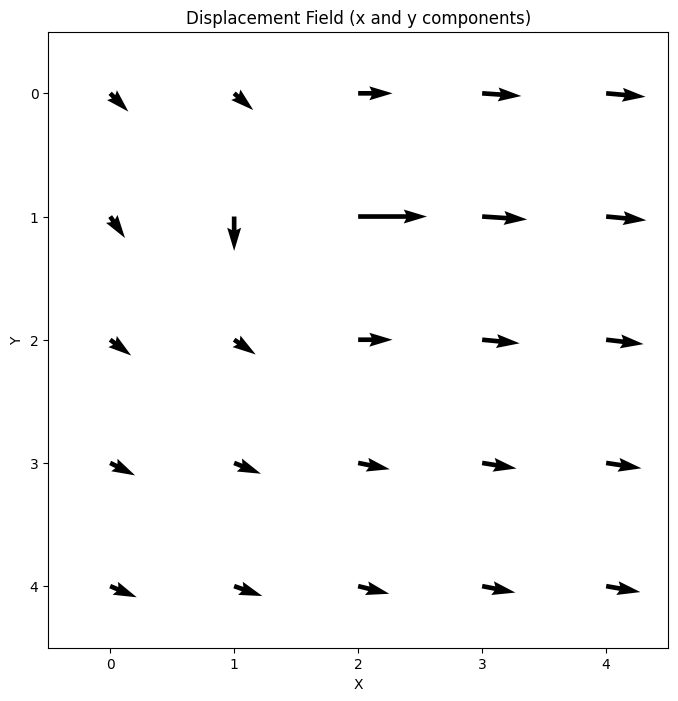

[[ 0.53010225  0.55623401  0.99995164  1.13879313  1.14477953]
 [ 0.43157839 -0.          1.99990328  1.30880741  1.16795141]
 [ 0.6125689   0.62603549  0.99995164  1.09095331  1.08907442]
 [ 0.72630917  0.77816414  0.92006971  0.99959617  1.02633698]
 [ 0.77415021  0.82005915  0.90374338  0.96627306  0.99481115]]
[[-0.5324243  -0.48682653  0.         -0.07854603 -0.10116997]
 [-0.62492689 -0.99991003  0.         -0.08609761 -0.10942553]
 [-0.45970909 -0.42855835  0.         -0.10471805 -0.12740239]
 [-0.36316328 -0.31442643 -0.18336721 -0.16199441 -0.15630781]
 [-0.32492664 -0.2876996  -0.22247669 -0.188065   -0.17358965]]


In [13]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 2, 1],
    [0, 0, 4],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 2, 3],  # Middle
    [0, 1, 4],
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
A0 = np.zeros((A.shape[0], A.shape[1]))
A_expanded = np.block([
    [A.todense(), A0],
    [A0, A.todense()]
])
XYd = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()


# Example displacement field (3x1x5x5)
displacement_field = deformation


# Create a grid of points
x, y = np.meshgrid(np.arange(displacement_field.shape[3]), np.arange(displacement_field.shape[2]))

# Extract the x and y displacement components
u = -displacement_field[2, 0, :, :]  # Displacement in x-direction
v = displacement_field[1, 0, :, :]  # Displacement in y-direction

# Plot the displacement vectors using a quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.title('Displacement Field (x and y components)')
plt.xlim(-0.5, displacement_field.shape[3] - 0.5)
plt.ylim(-0.5, displacement_field.shape[2] - 0.5)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X')
plt.ylabel('Y')
#plt.grid()
plt.show()

print(u)
print(v)